<a href="https://colab.research.google.com/github/ericzacharia/Predicting-Stocks-with-Twitter-Sentiment/blob/main/sentiment_model.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
while True:
    PRETRAINED = input(f'''Would you like to use the last saved trained model (p) or overwrite it with a new training session (train_new_model)?
p: pretrained
new: overwrite with new session
''')
    if PRETRAINED == 'p': 
        PRETRAINED = True
        break
    elif PRETRAINED == 'new':
        PRETRAINED = False
        break
    else:
        print("Invalid respponse. type p: pretrained, or train_new_model: overwrite with new session")

while True:
    COLAB = input(f'''Type (g) if you are using Google Colab with GPU or (l) if you are running on your local machine's CPU.
g: Google Colab
l: local 
''')
    if COLAB == 'g':
        COLAB = True
        from google.colab import drive
        drive.mount('/content/drive')
        # %pip install -r requirements.txt
        break
    elif COLAB == 'l':
        COLAB = False
        break
    else:
        print("Invalid response. type gc: Google Colab, or local: local machine")

RANDOM_SEED = 42
RISK_LEVEL = 0.2  # (conservative) 0.0 to 1.0 (risky)

Would you like to use the last saved trained model (p) or overwrite it with a new training session (train_new_model)?
p: pretrained
new: overwrite with new session
p
Type (g) if you are using Google Colab with GPU or (l) if you are running on your local machine's CPU.
g: Google Colab
l: local 
g
Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 26.2 MB/s 
     |████████████████████████████████| 7.6 MB 54.8 MB/s 
     |████████████████████████████████| 163 kB 73.2 MB/s 


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
%matplotlib inline

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = './'
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    path = '/content/gdrive/My Drive/'  


Mounted at /content/gdrive/


In [5]:
df = pd.read_csv(f"{path}stock_data.csv", sep=',')
df.shape

(5791, 2)

In [6]:
df.tail()

,Text,Sentiment
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1
5790,"#Sensex, #Nifty climb off day's highs, still u...",1


In [7]:
df.Sentiment.replace(-1,0,inplace=True)
df.tail()

,Text,Sentiment
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1
5790,"#Sensex, #Nifty climb off day's highs, still u...",1


In [8]:
class StockTweetsDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)}


In [9]:
# Split 80-10-10
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4632, 2), (579, 2), (580, 2))

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = StockTweetsDataset(tweets=df.Text.to_numpy(), targets=df.Sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [11]:
BATCH_SIZE = 16
MAX_LEN = 80  # All tweets in the data set contain fewer than 80 tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', return_dict=False)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.dropout(output)
    return self.out(output)


In [13]:
class_names = ['bearish', 'bullish']

if not PRETRAINED:
    data = next(iter(train_data_loader))
    data.keys()
    print(data['input_ids'].shape)
    print(data['attention_mask'].shape)
    print(data['targets'].shape)
    model = SentimentClassifier(len(class_names))
    model = model.to(device)
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    F.softmax(model(input_ids, attention_mask), dim=1)
    EPOCHS = 10
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = nn.CrossEntropyLoss().to(device)


In [14]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [15]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:

PATH = 'twitter_sentiment_model.pth'  # filename for the pretrained model

if not PRETRAINED:
    %%time
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            device = torch.device("cuda")
            model.to(device)
            torch.save({
                'history': history,
                'epoch': EPOCHS,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, PATH)
            best_accuracy = val_acc
else:
    model = SentimentClassifier(len(class_names))
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

    if COLAB:
        PATH = path + PATH
        device = torch.device('cuda')
        checkpoint = torch.load(PATH)
        model.to(device)
    else:
        device = torch.device('cpu')
        checkpoint = torch.load(PATH, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    # history = checkpoint['history']

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a f

In [17]:
if not PRETRAINED:
    test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
    test_acc.item()

In [18]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweets = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)
            tweets.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweets, predictions, prediction_probs, real_values

In [19]:
# This section is used to calculate predictions and save them to a .csv file
# or load them from the saved .csv file from the pretrained model.
if not PRETRAINED:
    y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
        model, test_data_loader)
    y_pred_probs = torch.squeeze(y_pred_probs.reshape(-1, 1))
    y_pred_probs_bearish = y_pred_probs[:y_pred_probs.size(0)//2]
    y_pred_probs_bullish = y_pred_probs[y_pred_probs.size(0)//2:]
    outcome_df = pd.DataFrame({"y_tweets": y_tweets})
    outcome_df['y_pred'] = y_pred
    outcome_df['y_pred_probs_bearish'] = y_pred_probs_bearish
    outcome_df['y_pred_probs_bullish'] = y_pred_probs_bullish
    outcome_df['y_test'] = y_test
    outcome_df.to_csv(f"{path}twitter_sentiment_outcomes.csv")
else:
    outcome_df = pd.read_csv(f"{path}twitter_sentiment_outcomes.csv")
    y_tweets = outcome_df.y_tweets.tolist()
    y_pred = torch.tensor(outcome_df.y_pred.tolist())
    y_pred_probs_bearish = torch.tensor(
        outcome_df.y_pred_probs_bearish.to_list()).reshape(-1, 2)
    y_pred_probs_bullish = torch.tensor(
        outcome_df.y_pred_probs_bullish.tolist()).reshape(-1, 2)
    y_pred_probs = torch.cat((y_pred_probs_bearish, y_pred_probs_bullish), 0)
    y_test = torch.tensor(outcome_df.y_test.tolist())


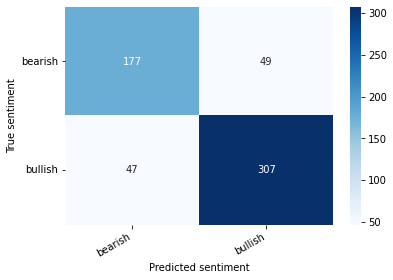

In [20]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [21]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     bearish       0.79      0.78      0.79       226
     bullish       0.86      0.87      0.86       354

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.83      0.83      0.83       580



In [22]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 23.7 MB/s 
     |████████████████████████████████| 182 kB 67.0 MB/s 
     |████████████████████████████████| 4.7 MB 61.1 MB/s 
     |████████████████████████████████| 164 kB 65.5 MB/s 
     |████████████████████████████████| 237 kB 61.9 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=6517ffc9fe12f9213a52cc25a923593c548527fe3885f39f8c7d71a33409d08d
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [23]:
import tweepy
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import Stream
from tweepy import OAuthHandler
from tweepy import Stream
import numpy as np
import pandas as pd
import re
import time
#import api_credentials 

import altair as alt
import streamlit as st
#import twitter_api
#import predict_live_tweets
#import trading_algorithm
#import time_series_plot
import numpy as np
import pandas as pd
import torch
from torch import nn
import time
from transformers import BertModel, AdamW

In [24]:
import numpy as np
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', return_dict=False)
MAX_LEN = 80  # All tweets in the data set contain fewer than 80 tokens
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict_tweets(model, df, risk_level=0.2):
    '''
    The method that handles prediction of tweet sentiment accepts as arguments the sentiment 
    classification model, the Pandas data frame of recent tweets, and the user’s desired risk 
    level for stock trading, which is a value between zero (most conservative) and one (most risky). 
    
    Next, it determines whether to trade a stock based on the certainty of the model’s prediction 
    about the sentiment of tweets it has just analyzed. If the user sets their desired risk level 
    closer to zero, then the BERT model is required to be more certain about its prediction before 
    making a trade, thus decreasing the volume of trades that occur. Since the BERT model computes 
    a likelihood score for both the bullish and bearish classifications for a tweet, certainty is 
    defined as the difference between the two scores. 

    The method also keeps a tally for a total polarity score for the incoming data frame, which 
    increments by one with each certain bullish prediction and decrements by one with each certain 
    bearish prediction. Bullish and bearish predictions that do not meet the minimum level of 
    certainty specified by the risk level do not affect the polarity score.

    The absolute value of the polarity score functions as a multiplier that contributes towards 
    the decision of how many shares to buy of the specified stock. Thus, a polarity score of zero 
    multiplies by zero, which results in not making any trades with that stock. Essentially, a 
    score of zero means that the accumulated sentimental predictions of certainty from all of 
    the tweets in the data frame was neutral, and this begins to happen more often as the user 
    decreases the input of the risk level of their trading strategy.
    '''
    trade_bool = False
    polarity = 0
    min_certainty = 7 - (risk_level*4)
    predictions = []
    for tweet in df.tweet:
        encoded_tweet = tokenizer.encode_plus(tweet, max_length=MAX_LEN, 
        add_special_tokens=True, return_token_type_ids=False, padding=True, 
        return_attention_mask=True, return_tensors='pt')
        input_ids = encoded_tweet['input_ids'].to(device)
        attention_mask = encoded_tweet['attention_mask'].to(device)
        output = model(input_ids, attention_mask)
        max_score, prediction = torch.max(output, dim=1)
        predictions.append(prediction.item())
        min_score, _ = torch.min(output, dim=1)
        certainty = (max_score - min_score).item()
        if certainty >= min_certainty:
            if prediction.item() == 0:
                polarity -= 1
            else:
                polarity += 1
    if polarity > 0 or polarity < 0:
        trade_bool = True

    df['prediction'] = np.array(predictions)

    return polarity, trade_bool, df


In [25]:
class TwitterAuthenticator():
    '''
    Used to authenticate my Twitter Developer account for permission to use the Twitter API
    '''

    def authenticate_twitter_app(self):
        TWITTER_ACCESS_TOKEN = "1520860285678256128-2NoMpb2kPez2Jbc51g4LJZAgyjXy2I"
        TWITTER_ACCESS_TOKEN_SECRET = "mAyA7UvTsYZyhXU9dtppKKJJsRTvrH36xlkcnmh1CteSl"
        TWITTER_CONSUMER_KEY = "g4LqevIEoAfUFTkSv8WwJJ6Rb"
        TWITTER_CONSUMER_SECRET = "85tX4q0JL0lUJoTRbVNnNGeRP7Rs2hwht6KFhKmifbr52sqlyU"
        auth = OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
        auth.set_access_token(TWITTER_ACCESS_TOKEN,
                              TWITTER_ACCESS_TOKEN_SECRET)                              
        '''
        #consumer_key = api_credentials.consumer_key
        #consumer_secret = api_credentials.consumer_secret

        consumer_key = "PPHYaMbm4oiuxFd7i0EHFFeIm"
        consumer_secret = "aYbfa4swirS15t8Q5nIE8MUtBVkjAVuTYJNKvEqFTngxtyiMVx"

        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(consumer_key, consumer_secret)

        # Redirect user to Twitter to authorize
        #redirect_user(auth.get_authorization_url())

        # Get access token
        #auth.get_access_token("verifier_value")
        '''

        return auth


class TwitterClient():
    '''
    A class for connecting to the Twitter API
    '''

    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets


class TwitterStreamer():
    """
    A class for streaming live tweets.
    """

    def __init__(self):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()

    def stream_tweets(self, hash_tag_list):
        listener = TwitterListener()
        stream = Stream(self.auth, listener)

        # Filter Twitter streams by keywords
        stream.filter(track=hash_tag_list)


class TwitterListener(Stream):
    '''
    An exponentially increasing time-out penalty is applied to a developer's account each time Twitter's request limit is exceeded.
    This listener will stop the program from running if it recieves an error code 420, 
    which is an indication that our program is about to exceed the tweet request limit.    
    
    A maximum of 450 recent search requests for tweets is allowed every 15 minutes.
    '''

    def on_error(self, status):
        if status == 420:
            # Return False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetPreprocessor():

    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def tweets_to_data_frame(self, tweets):
        '''
        Returns the data frame of tweets and the latest tweet id, 
        so that the next function call will only include tweets after 
        the latest tweet id to avoid duplication.

        Input: tweepy.models.SearchResults (a JSON data structure of tweets)
        Outputs: a pandas data frame of recent tweets and the latest tweet id
        '''
        df = pd.DataFrame(data=[self.clean_tweet(tweet.text)
                          for tweet in tweets], columns=['tweet'])

        df['id'] = np.array([tweet.id for tweet in tweets])

        # The lastest tweet id is conveiniently the largest number
        latest_id = df.id.max()

        # # If you want to drop retweets from data frame
        # df = df[~df.tweet.str.contains("RT")]

        return df, latest_id

In [26]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.dropout(output)
    return self.out(output)

#sp500_stocks = ["$TCS", "$AAL", "$AAP", "$AAPL", "$ABBV", "$ABC", "$ABMD", "$ABT", "$ACN", "$ADBE", "$ADI", "$ADM", "$ADP", "$ADSK", "$AEE", "$AEP", "$AES", "$AFL", "$AIG", "$AIZ", "$AJG", "$AKAM", "$ALB", "$ALGN", "$ALK", "$ALL", "$ALLE", "$AMAT", "$AMCR", "$AMD", "$AME", "$AMGN", "$AMP", "$AMT", "$AMZN", "$ANET", "$ANSS", "$ANTM", "$AON", "$AOS", "$APA", "$APD", "$APH", "$APTV", "$ARE", "$ATO", "$ATVI", "$AVB", "$AVGO", "$AVY", "$AWK", "$AXP", "$AZO", "$BA", "$BAC", "$BAX", "$BBWI", "$BBY", "$BDX", "$BEN", "$BF.B", "$BIIB", "$BIO", "$BK", "$BKNG", "$BKR", "$BLK", "$BLL", "$BMY", "$BR", "$BRK.B", "$BRO", "$BSX", "$BWA", "$BXP", "$C", "$CAG", "$CAH", "$CARR", "$CAT", "$CB", "$CBOE", "$CBRE", "$CCI", "$CCL", "$CDAY", "$CDNS", "$CDW", "$CE", "$CEG", "$CERN", "$CF", "$CFG", "$CHD", "$CHRW", "$CHTR", "$CI", "$CINF", "$CL", "$CLX", "$CMA", "$CMCSA", "$CME", "$CMG", "$CMI", "$CMS", "$CNC", "$CNP", "$COF", "$COO", "$COP", "$COST", "$CPB", "$CPRT", "$CPT", "$CRL", "$CRM", "$CSCO", "$CSX", "$CTAS", "$CTLT", "$CTRA", "$CTSH", "$CTVA", "$CTXS", "$CVS", "$CVX", "$CZR", "$D", "$DAL", "$DD", "$DE", "$DFS", "$DG", "$DGX", "$DHI", "$DHR", "$DIS", "$DISH", "$DLR", "$DLTR", "$DOV", "$DOW", "$DPZ", "$DRE", "$DRI", "$DTE", "$DUK", "$DVA", "$DVN", "$DXC", "$DXCM", "$EA", "$EBAY", "$ECL", "$ED", "$EFX", "$EIX", "$EL", "$EMN", "$EMR", "$ENPH", "$EOG", "$EPAM", "$EQIX", "$EQR", "$ES", "$ESS", "$ETN", "$ETR", "$ETSY", "$EVRG", "$EW", "$EXC", "$EXPD", "$EXPE", "$EXR", "$F", "$FANG", "$FAST", "$FB", "$FBHS", "$FCX", "$FDS", "$FDX", "$FE", "$FFIV", "$FIS", "$FISV", "$FITB", "$FLT", "$FMC", "$FOX", "$FOXA", "$FRC", "$FRT", "$FTNT", "$FTV", "$GD", "$GE", "$GILD", "$GIS", "$GL", "$GLW", "$GM", "$GNRC", "$GOOG", "$GOOGL", "$GPC", "$GPN", "$GRMN", "$GS", "$GWW", "$HAL", "$HAS", "$HBAN", "$HCA", "$HD", "$HES", "$HIG", "$HII", "$HLT", "$HOLX", "$HON", "$HPE", "$HPQ", "$HRL", "$HSIC", "$HST", "$HSY", "$HUM", "$HWM", "$IBM", "$ICE", "$IDXX", "$IEX", "$IFF", "$ILMN", "$INCY", "$INTC", "$INTU", "$IP", "$IPG", "$IPGP", "$IQV", "$IR", "$IRM", "$ISRG", "$IT", "$ITW", "$IVZ", "$J", "$JBHT", "$JCI", "$JKHY", "$JNJ", "$JNPR", "$JPM", "$K", "$KEY", "$KEYS", "$KHC", "$KIM", "$KLAC", "$KMB", "$KMI", "$KMX", "$KO", "$KR", "$L", "$LDOS", "$LEN", "$LH", "$LHX", "$LIN", "$LKQ", "$LLY", "$LMT", "$LNC", "$LNT", "$LOW", "$LRCX", "$LUMN", "$LUV", "$LVS", "$LW", "$LYB", "$LYV", "$MA", "$MAA", "$MAR", "$MAS", "$MCD", "$MCHP", "$MCK", "$MCO", "$MDLZ", "$MDT", "$MET", "$MGM", "$MHK", "$MKC", "$MKTX", "$MLM", "$MMC", "$MMM", "$MNST", "$MO", "$MOH", "$MOS", "$MPC", "$MPWR", "$MRK", "$MRNA", "$MRO", "$MS", "$MSCI", "$MSFT", "$MSI", "$MTB", "$MTCH", "$MTD", "$MU", "$NCLH", "$NDAQ", "$NDSN", "$NEE", "$NEM", "$NFLX", "$NI", "$NKE", "$NLOK", "$NLSN", "$NOC", "$NOW", "$NRG", "$NSC", "$NTAP", "$NTRS", "$NUE", "$NVDA", "$NVR", "$NWL", "$NWS", "$NWSA", "$NXPI", "$O", "$ODFL", "$OGN", "$OKE", "$OMC", "$ORCL", "$ORLY", "$OTIS", "$OXY", "$PARA", "$PAYC", "$PAYX", "$PCAR", "$PEAK", "$PEG", "$PENN", "$PEP", "$PFE", "$PFG", "$PG", "$PGR", "$PH", "$PHM", "$PKG", "$PKI", "$PLD", "$PM", "$PNC", "$PNR", "$PNW", "$POOL", "$PPG", "$PPL", "$PRU", "$PSA", "$PSX", "$PTC", "$PVH", "$PWR", "$PXD", "$PYPL", "$QCOM", "$QRVO", "$RCL", "$RE", "$REG", "$REGN", "$RF", "$RHI", "$RJF", "$RL", "$RMD", "$ROK", "$ROL", "$ROP", "$ROST", "$RSG", "$RTX", "$SBAC", "$SBNY", "$SBUX", "$SCHW", "$SEDG", "$SEE", "$SHW", "$SIVB", "$SJM", "$SLB", "$SNA", "$SNPS", "$SO", "$SPG", "$SPGI", "$SRE", "$STE", "$STT", "$STX", "$STZ", "$SWK", "$SWKS", "$SYF", "$SYK", "$SYY", "$T", "$TAP", "$TDG", "$TDY", "$TECH", "$TEL", "$TER", "$TFC", "$TFX", "$TGT", "$TJX", "$TMO", "$TMUS", "$TPR", "$TRMB", "$TROW", "$TRV", "$TSCO", "$TSLA", "$TSN", "$TT", "$TTWO", "$TWTR", "$TXN", "$TXT", "$TYL", "$UA", "$UAA", "$UAL", "$UDR", "$UHS", "$ULTA", "$UNH", "$UNP", "$UPS", "$URI", "$USB", "$V", "$VFC", "$VLO", "$VMC", "$VNO", "$VRSK", "$VRSN", "$VRTX", "$VTR", "$VTRS", "$VZ", "$WAB", "$WAT", "$WBA", "$WBD", "$WDC", "$WEC", "$WELL", "$WFC", "$WHR", "$WM", "$WMB", "$WMT", "$WRB", "$WRK", "$WST", "$WTW", "$WY", "$WYNN", "$XEL", "$XOM", "$XRAY", "$XYL", "$YUM", "$ZBH", "$ZBRA", "$ZION", "$ZTS"]
sp500_stocks = ["$TCS"]

class_names = ['bearish', 'bullish']
model = SentimentClassifier(len(class_names))
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
device = torch.device('cpu')
checkpoint = torch.load("/content/gdrive/MyDrive/twitter_sentiment_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
equities = []
datetimes = []

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a f

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0           AAPL Target Price Sold limit Take profits           1   
1            Welcome to our CHATR00M for real traders           1   
2   RT AAPL drops after a report the company is cu...           0   
3   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
4   Look at how many green trades our top analysts...           1   
5   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
6   RT Dividend Stocks at the Top of My Watchlist ...           1   
7   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
8   Daily market recap video in this approximate o...           1   
9   The AAPL MacD just crossed Bullish the last 2 ...           1   
10  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
11  RT How to use the Mid Candle Look for the Gold...           1   
12  RT Trade Alert Experience Trade Ideas Premium ...           1   
13  RT Trade Alert Experience Trad

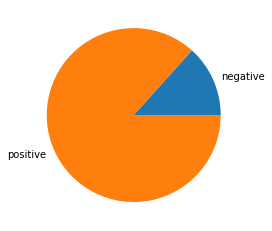

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0           AAPL Target Price Sold limit Take profits           1   
1            Welcome to our CHATR00M for real traders           1   
2   RT AAPL drops after a report the company is cu...           0   
3   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
4   Look at how many green trades our top analysts...           1   
5   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
6   RT Dividend Stocks at the Top of My Watchlist ...           1   
7   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
8   Daily market recap video in this approximate o...           1   
9   The AAPL MacD just crossed Bullish the last 2 ...           1   
10  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
11  RT How to use the Mid Candle Look for the Gold...           1   
12  RT Trade Alert Experience Trade Ideas Premium ...           1   
13  RT Trade Alert Experience Trad

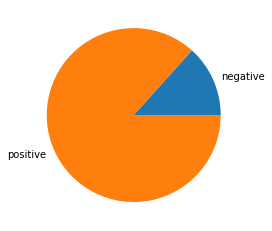

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0           AAPL Target Price Sold limit Take profits           1   
1            Welcome to our CHATR00M for real traders           1   
2   RT AAPL drops after a report the company is cu...           0   
3   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
4   Look at how many green trades our top analysts...           1   
5   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
6   RT Dividend Stocks at the Top of My Watchlist ...           1   
7   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
8   Daily market recap video in this approximate o...           1   
9   The AAPL MacD just crossed Bullish the last 2 ...           1   
10  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
11  RT How to use the Mid Candle Look for the Gold...           1   
12  RT Trade Alert Experience Trade Ideas Premium ...           1   
13  RT Trade Alert Experience Trad

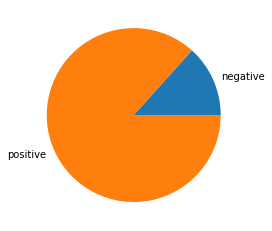

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0           AAPL Target Price Sold limit Take profits           1   
1            Welcome to our CHATR00M for real traders           1   
2   RT AAPL drops after a report the company is cu...           0   
3   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
4   Look at how many green trades our top analysts...           1   
5   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
6   RT Dividend Stocks at the Top of My Watchlist ...           1   
7   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
8   Daily market recap video in this approximate o...           1   
9   The AAPL MacD just crossed Bullish the last 2 ...           1   
10  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
11  RT How to use the Mid Candle Look for the Gold...           1   
12  RT Trade Alert Experience Trade Ideas Premium ...           1   
13  RT Trade Alert Experience Trad

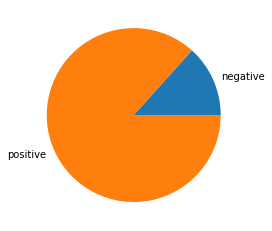

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0           AAPL Target Price Sold limit Take profits           1   
1            Welcome to our CHATR00M for real traders           1   
2   RT AAPL drops after a report the company is cu...           0   
3   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
4   Look at how many green trades our top analysts...           1   
5   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
6   RT Dividend Stocks at the Top of My Watchlist ...           1   
7   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
8   Daily market recap video in this approximate o...           1   
9   The AAPL MacD just crossed Bullish the last 2 ...           1   
10  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
11  RT How to use the Mid Candle Look for the Gold...           1   
12  RT Trade Alert Experience Trade Ideas Premium ...           1   
13  RT Trade Alert Experience Trad

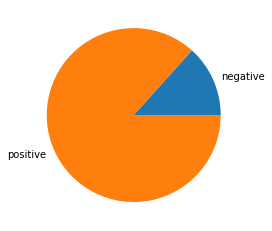

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0           AAPL Target Price Sold limit Take profits           1   
1            Welcome to our CHATR00M for real traders           1   
2   RT AAPL drops after a report the company is cu...           0   
3   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
4   Look at how many green trades our top analysts...           1   
5   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
6   RT Dividend Stocks at the Top of My Watchlist ...           1   
7   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
8   Daily market recap video in this approximate o...           1   
9   The AAPL MacD just crossed Bullish the last 2 ...           1   
10  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
11  RT How to use the Mid Candle Look for the Gold...           1   
12  RT Trade Alert Experience Trade Ideas Premium ...           1   
13  RT Trade Alert Experience Trad

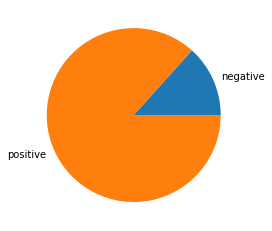

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0   I have shared that in my past tweets I have a ...           1   
1           AAPL Target Price Sold limit Take profits           1   
2            Welcome to our CHATR00M for real traders           1   
3   RT AAPL drops after a report the company is cu...           0   
4   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
5   Look at how many green trades our top analysts...           1   
6   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
7   RT Dividend Stocks at the Top of My Watchlist ...           1   
8   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
9   Daily market recap video in this approximate o...           1   
10  The AAPL MacD just crossed Bullish the last 2 ...           1   
11  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
12  RT How to use the Mid Candle Look for the Gold...           1   
13  RT Trade Alert Experience Trad

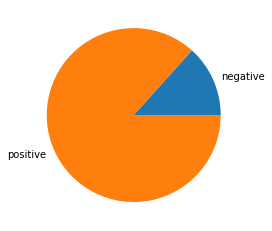

Empty DataFrame
Columns: [tweet, prediction, id]
Index: []


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                                tweet  prediction  \
0   I have shared that in my past tweets I have a ...           1   
1           AAPL Target Price Sold limit Take profits           1   
2            Welcome to our CHATR00M for real traders           1   
3   RT AAPL drops after a report the company is cu...           0   
4   RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
5   Look at how many green trades our top analysts...           1   
6   RT Wujastyk AAPL AAPL Recent MACD bull cross w...           1   
7   RT Dividend Stocks at the Top of My Watchlist ...           1   
8   SPY SPY MSFT MSFT AAPL AAPL AMZN AMZN QQQ QQQ ...           0   
9   Daily market recap video in this approximate o...           1   
10  The AAPL MacD just crossed Bullish the last 2 ...           1   
11  RT Technical Stocks Analysis for 10 19 22 ES Q...           1   
12  RT How to use the Mid Candle Look for the Gold...           1   
13  RT Trade Alert Experience Trad

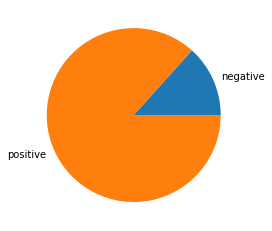

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2319: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


                                               tweet  prediction  \
0  Join our Alerts amp Options SPY NFLX M DIS OPG...           1   

                    id  
0  1582580809705218048  


KeyError: ignored

In [27]:
twitter_client = TwitterClient()
tweet_preprocessor = TweetPreprocessor()
api = twitter_client.get_twitter_client_api()
latest_id = None
hash_tag_dict = {sp500_stocks[i]: None for i in range(len(sp500_stocks))}

negatives, positives =0,0

while True:
  for ticker in hash_tag_dict.keys():
      tweets = api.search(q=ticker, lang='en', result_type='recent', since_id=hash_tag_dict[ticker])
      df, latest_id = tweet_preprocessor.tweets_to_data_frame(tweets)
      hash_tag_dict[ticker] = latest_id  # update the current ticker to the latest tweet id
      polarity, trade_bool, df = predict_tweets(model, df, risk_level=RISK_LEVEL)
      #df.loc[df['prediction'] == 0, 'prediction'] = 'Sell'
      print(df[['tweet', 'prediction', 'id']])

      result = df['prediction'].value_counts().to_dict()
      if (len(result) != 0):
        negatives = negatives + result[0]
        positives = positives + result[1]
        plt.pie([negatives, positives], labels=['negative', 'positive'])
        plt.show()